In [1]:
## load necessary modules
import argparse
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from utils.tools import *
from utils.losses import *
from models.cifar10 import *

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from datetime import datetime
now = datetime.now()
timestamp = now.strftime("%m_%d_%H%M")
print(timestamp)

02_20_0047


In [2]:
# Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # check if gpu is available

## load datasets
# train_gen, dev_gen, test_gen = load(batch_size, batch_size)
# data = inf_train_gen_mnist(train_gen)
img_size = 64
transform    = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(img_size, antialias=True),
    transforms.Normalize((0.5, 0.5, 0.5),  # Normalize the image
                         (0.5, 0.5, 0.5))
])
train_gen    = dsets.CIFAR10(root="./datasets",train=True, transform=transform, download=True)
test_gen     = dsets.CIFAR10(root="./datasets",train=False, transform=transform, download=True)
# train_loader = DataLoader(train_gen, batch_size=batch_size, shuffle=True)
# test_loader  = DataLoader(test_gen, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
## hyper-parameters
n_rep = 10
epochs1 = 100
epochs2 = 120
std = 0.1
lr_GI = 1e-4
lr_D = 5e-4
weight_decay = 0.01
batch_size = 250
z_dim = 4
lambda_mmd = 1.5
lambda_gp = 0.1
lambda_power = 0.5
eta = 3.0
dirichlet_alpha = 3.0
present_label = list(range(10))
missing_label = []
all_label     = present_label + missing_label
classes       = train_gen.classes

In [26]:
np.random.seed(7)
# Step 1: Generate Dirichlet distribution weights
weights = np.random.dirichlet([dirichlet_alpha] * len(present_label))
# Step 2: Calculate the number of samples for each class
total_samples = len(train_gen.data)
samples_per_class = np.round(weights * total_samples).astype(int)
# Adjust to make sure the total is equal to the original test set size
samples_per_class[-1] = total_samples - np.sum(samples_per_class[:-1])
sampled_idxs = []
for idx, lab in enumerate(present_label):    
    if torch.is_tensor(train_gen.targets):
        class_idxs = torch.where(train_gen.targets == lab)[0] 
    else:
        class_idxs = torch.where(torch.Tensor(train_gen.targets) == lab)[0] 
    temp = np.random.choice(class_idxs, size=samples_per_class[idx], replace=True)
    sampled_idxs.append(torch.Tensor(temp).int())
print(samples_per_class)

[2953 2353 3990 7020 5637 5350 3381 5497 4295 9524]


In [5]:
# ************************
# *** DPI-RG Algorithm ***
# ************************

cover_accs = []
avg_counts = []

# for rep in range(n_rep):
T_trains = []
for lab in present_label:
    print('-'*100)
    print(f'Class {lab} Started')
    print('-'*100)
    ## initialize models
    netI = I_CIFAR10_2(nz=z_dim)
    netG = G_CIFAR10(nz=z_dim, ngf = 48, img_size = 64)
    netD = D_CIFAR10(nz=z_dim, ndf = 32)
    netI = netI.to(device)
    netG = netG.to(device)
    netD = netD.to(device)
    netI = nn.DataParallel(netI)
    netG = nn.DataParallel(netG)
    netD = nn.DataParallel(netD)

    ## set up optimizers
    optim_I = optim.Adam(netI.parameters(), lr=lr_GI, betas=(0.5, 0.999))
    optim_G = optim.Adam(netG.parameters(), lr=lr_GI, betas=(0.5, 0.999))
    optim_D = optim.Adam(netD.parameters(), lr=lr_D, betas=(0.5, 0.999), 
                         weight_decay=weight_decay)
    ## filter data for each label and train them respectively
    train_data = torch.utils.data.Subset(train_gen, sampled_idxs[lab])
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    
    ## train for the first time
    train_al(netI, netG, netD, optim_I, optim_G, optim_D,
             train_gen, train_loader, batch_size, 0, epochs1, 
             z_dim, device, lab, present_label, all_label, 
             lambda_gp, lambda_power, lambda_mmd = lambda_mmd,
             img_size = img_size, nc = 3, eta = eta, sampled_idxs = sampled_idxs, 
             lr_decay = 40, trace=True, critic_iter = 10, critic_iter_d = 10, critic_iter_p = 5)

    ## find out fake_zs
    fake_zs = []
    with torch.no_grad(): 
        for i, batch in enumerate(train_loader):
            x, _ = batch
            fake_z = netI(x.to(device))
            fake_zs.append(fake_z)
    fake_zs = torch.cat(fake_zs)
    ## get the empirical distribution for each label
    T_train = torch.sqrt(torch.sum(fake_zs ** 2, dim=1) + 1)

    ## get powers to determine new sample sizes
    powers = []
    for cur_lab in present_label:    
        if cur_lab != lab:
            idxs3 = sampled_idxs[cur_lab]
            train_data3 = torch.utils.data.Subset(train_gen, idxs3)
            train_loader3  = DataLoader(train_data3, batch_size=batch_size, shuffle=False)
            p_vals = torch.zeros(len(idxs3)) 
            fake_zs = torch.zeros(len(idxs3))
            em_len = len(T_train)

            for i, batch in enumerate(train_loader3):
                x, _ = batch
                fake_z = netI(x.to(device))
                T_batch = torch.sqrt(torch.sum(fake_z ** 2, dim=1) + 1)

                # compute p-value for each sample
                for j in range(len(fake_z)):
                    p1 = torch.sum(T_train > T_batch[j]) / em_len
                    p = p1
                    # calculate the p-value and put it in the corresponding list
                    p_vals[i * batch_size + j] = p.item()
            powers.append(np.sum(np.array(p_vals) <= 0.05) / len(idxs3))
            
    sample_sizes = max(powers) - powers + 0.05
    sample_sizes = (sample_sizes / sum(sample_sizes) * len(idxs3)).astype(int)
    # print(sample_sizes)
    ## train for the second time according to the calculated sample sizes
    train_al(netI, netG, netD, optim_I, optim_G, optim_D,
             train_gen, train_loader, batch_size, epochs1, epochs2, 
             z_dim, device, lab, present_label, all_label, 
             lambda_gp, lambda_power, lambda_mmd = lambda_mmd, sample_sizes = sample_sizes, 
             img_size = img_size, nc = 3, eta = eta, sampled_idxs = sampled_idxs, 
             lr_decay = None, trace = True, critic_iter = 5, critic_iter_d = 5, critic_iter_p = 5)
    
    ## find out fake_zs
    fake_zs = []
    with torch.no_grad(): 
        for i, batch in enumerate(train_loader):
            x, _ = batch
            fake_z = netI(x.to(device))
            fake_zs.append(fake_z)
    fake_zs = torch.cat(fake_zs)
    ## get the empirical distribution for each label
    T_train = torch.sqrt(torch.sum(fake_zs ** 2, dim=1) + 1)
    T_trains.append(T_train)

    ## save net and graphs for each label
    model_save_file = f'cifar10_param/{timestamp}_class{lab}.pt'
    torch.save(netI.state_dict(), model_save_file)
    del netI
    print('-'*100)
    print(f'Class {lab} Finished')
    print('-'*100)

----------------------------------------------------------------------------------------------------
Class 0 Started
----------------------------------------------------------------------------------------------------
Epoch = 0
GI loss:  1.061986
MMD loss: 0.105944
D loss:   -0.002947
gp loss:  0.084005
power loss: 1.116711
Epoch = 1
GI loss:  0.643386
MMD loss: 0.025483
D loss:   -0.000258
gp loss:  0.086623
power loss: 1.123832
Epoch = 2
GI loss:  0.517949
MMD loss: 0.025246
D loss:   -0.013234
gp loss:  0.084570
power loss: 1.108790
Epoch = 3
GI loss:  0.541087
MMD loss: 0.019788
D loss:   -0.026406
gp loss:  0.083954
power loss: 1.128969
Epoch = 4
GI loss:  0.448263
MMD loss: 0.006736
D loss:   -0.023788
gp loss:  0.079620
power loss: 1.073275
Epoch = 5
GI loss:  0.473195
MMD loss: 0.009399
D loss:   -0.011198
gp loss:  0.083345
power loss: 1.100810
Epoch = 6
GI loss:  0.447882
MMD loss: 0.025611
D loss:   -0.009139
gp loss:  0.083191
power loss: 1.075552
Epoch = 7
GI loss:  0.4470

In [62]:
# ## get T_trains for imbalanced dataset
# T_trains = []
# for lab in present_label:
#     ## initialize models
#     netI = I_CIFAR10_2(nz=z_dim)
#     netI = netI.to(device)
#     netI = nn.DataParallel(netI)
#     model_save_file = f'cifar10_param/{timestamp}_class{lab}.pt'
#     netI.load_state_dict(torch.load(model_save_file))
#     ## filter data for each label and train them respectively
#     # train_data = torch.utils.data.Subset(train_gen, sampled_idxs[lab])
#     idxs2 = torch.where(torch.Tensor(train_gen.targets) == lab)[0] 
#     train_data = torch.utils.data.Subset(train_gen, idxs2)
#     train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
#     fake_zs = []
#     with torch.no_grad(): 
#         for i, batch in enumerate(train_loader):
#             x, _ = batch
#             fake_z = netI(x.to(device))
#             fake_zs.append(fake_z)
#     fake_zs = torch.cat(fake_zs)
#     ## get the empirical distribution for each label
#     T_train = torch.sqrt(torch.sum(fake_zs ** 2, dim=1) + 1)
#     T_trains.append(T_train)

In [64]:
# plt.hist(T_trains[4].cpu().flatten())
# plt.show()

In [12]:
# present_label = list(range(10))
# missing_label = []
# all_label     = present_label + missing_label

In [65]:
# training for verification
all_p_vals  = []
all_fake_Ts = []

for lab in all_label:    
    if torch.is_tensor(train_gen.targets):
        idxs2 = torch.where(train_gen.targets == lab)[0] 
    else:
        idxs2 = torch.where(torch.Tensor(train_gen.targets) == lab)[0] 
    train_data = torch.utils.data.Subset(train_gen, idxs2)
    train_loader  = DataLoader(train_data, batch_size=batch_size, shuffle=False)

    # p_vals and fake_zs store p-values, fake_zs for the current iteration
    fake_Ts = torch.zeros(len(present_label), len(idxs2))
    p_vals = torch.zeros(len(present_label), len(idxs2)) 

    for pidx in range(len(present_label)):
        T_train = T_trains[pidx]
        em_len = len(T_train)
        netI = I_CIFAR10_2(nz=z_dim)
        netI = netI.to(device)
        netI = torch.nn.DataParallel(netI)
        model_save_file = f'cifar10_param/{timestamp}_class{present_label[pidx]}.pt'
        netI.load_state_dict(torch.load(model_save_file))
        
        for i, batch in enumerate(train_loader):
            images, y = batch
            x = images.view(-1, 3, img_size ** 2).to(device)
            fake_z = netI(x)
            T_batch = torch.sqrt(torch.sum(torch.square(fake_z), 1) + 1) 
            ## compute p-value for each sample
            for j in range(len(fake_z)):
                p1 = torch.sum(T_train > T_batch[j]) / em_len
                # p2 = torch.sum(T_train < T_batch[j]) / em_len
                # p = 2*min(p1, p2)
                p = p1
                # calculate the p-value and put it in the corresponding list
                fake_Ts[pidx, i * batch_size + j] = T_batch[j].item()
                p_vals[pidx, i * batch_size + j] = p.item()

    all_p_vals.append(np.array(p_vals))
    ## concatenate torch data
    all_fake_Ts.append(np.array(fake_Ts))
    # print('Finished Label {}'.format(lab))

In [72]:
# visualize_T(all_fake_Ts, present_label, all_label, missing_label, z_dim, classes)

In [71]:
# visualize_p(all_p_vals, present_label, all_label, missing_label, z_dim, classes)

In [9]:
# plt.hist(all_fake_Ts[5].flatten())
# plt.show()
# plt.hist(T_trains[9].cpu().flatten())
# plt.show()

In [114]:
## test data set
all_p_vals  = []
all_fake_Ts = []

for lab in all_label:    
    if torch.is_tensor(test_gen.targets):
        idxs2 = torch.where(test_gen.targets == lab)[0] 
    else:
        idxs2 = torch.where(torch.Tensor(test_gen.targets) == lab)[0] 
    test_data = torch.utils.data.Subset(test_gen, idxs2)
    test_loader  = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    # p_vals and fake_zs store p-values, fake_zs for the current iteration
    fake_Ts = torch.zeros(len(present_label), len(idxs2))
    p_vals = torch.zeros(len(present_label), len(idxs2)) 

    for pidx in range(len(present_label)):
        T_train = T_trains[pidx]
        em_len = len(T_train)
        netI = I_CIFAR10_2(nz=z_dim)
        netI = netI.to(device)
        netI = torch.nn.DataParallel(netI)
        model_save_file = f'cifar10_param/{timestamp}_class{present_label[pidx]}.pt'
        netI.load_state_dict(torch.load(model_save_file))
        
        for i, batch in enumerate(test_loader):
            images, y = batch
            x = images.view(-1, 3, img_size ** 2).to(device)
            fake_z = netI(x)
            T_batch = torch.sqrt(torch.sum(torch.square(fake_z), 1) + 1) 
            ## compute p-value for each sample
            for j in range(len(fake_z)):
                p1 = torch.sum(T_train > T_batch[j]) / em_len
                p = p1
                # calculate the p-value and put it in the corresponding list
                fake_Ts[pidx, i * batch_size + j] = T_batch[j].item()
                p_vals[pidx, i * batch_size + j] = p.item()

    all_p_vals.append(np.array(p_vals))
    ## concatenate torch data
    all_fake_Ts.append(np.array(fake_Ts))
    # print('Finished Label {}'.format(lab))

----------------------------------------------------------------------------------------------------
                                             fake numbers
----------------------------------------------------------------------------------------------------


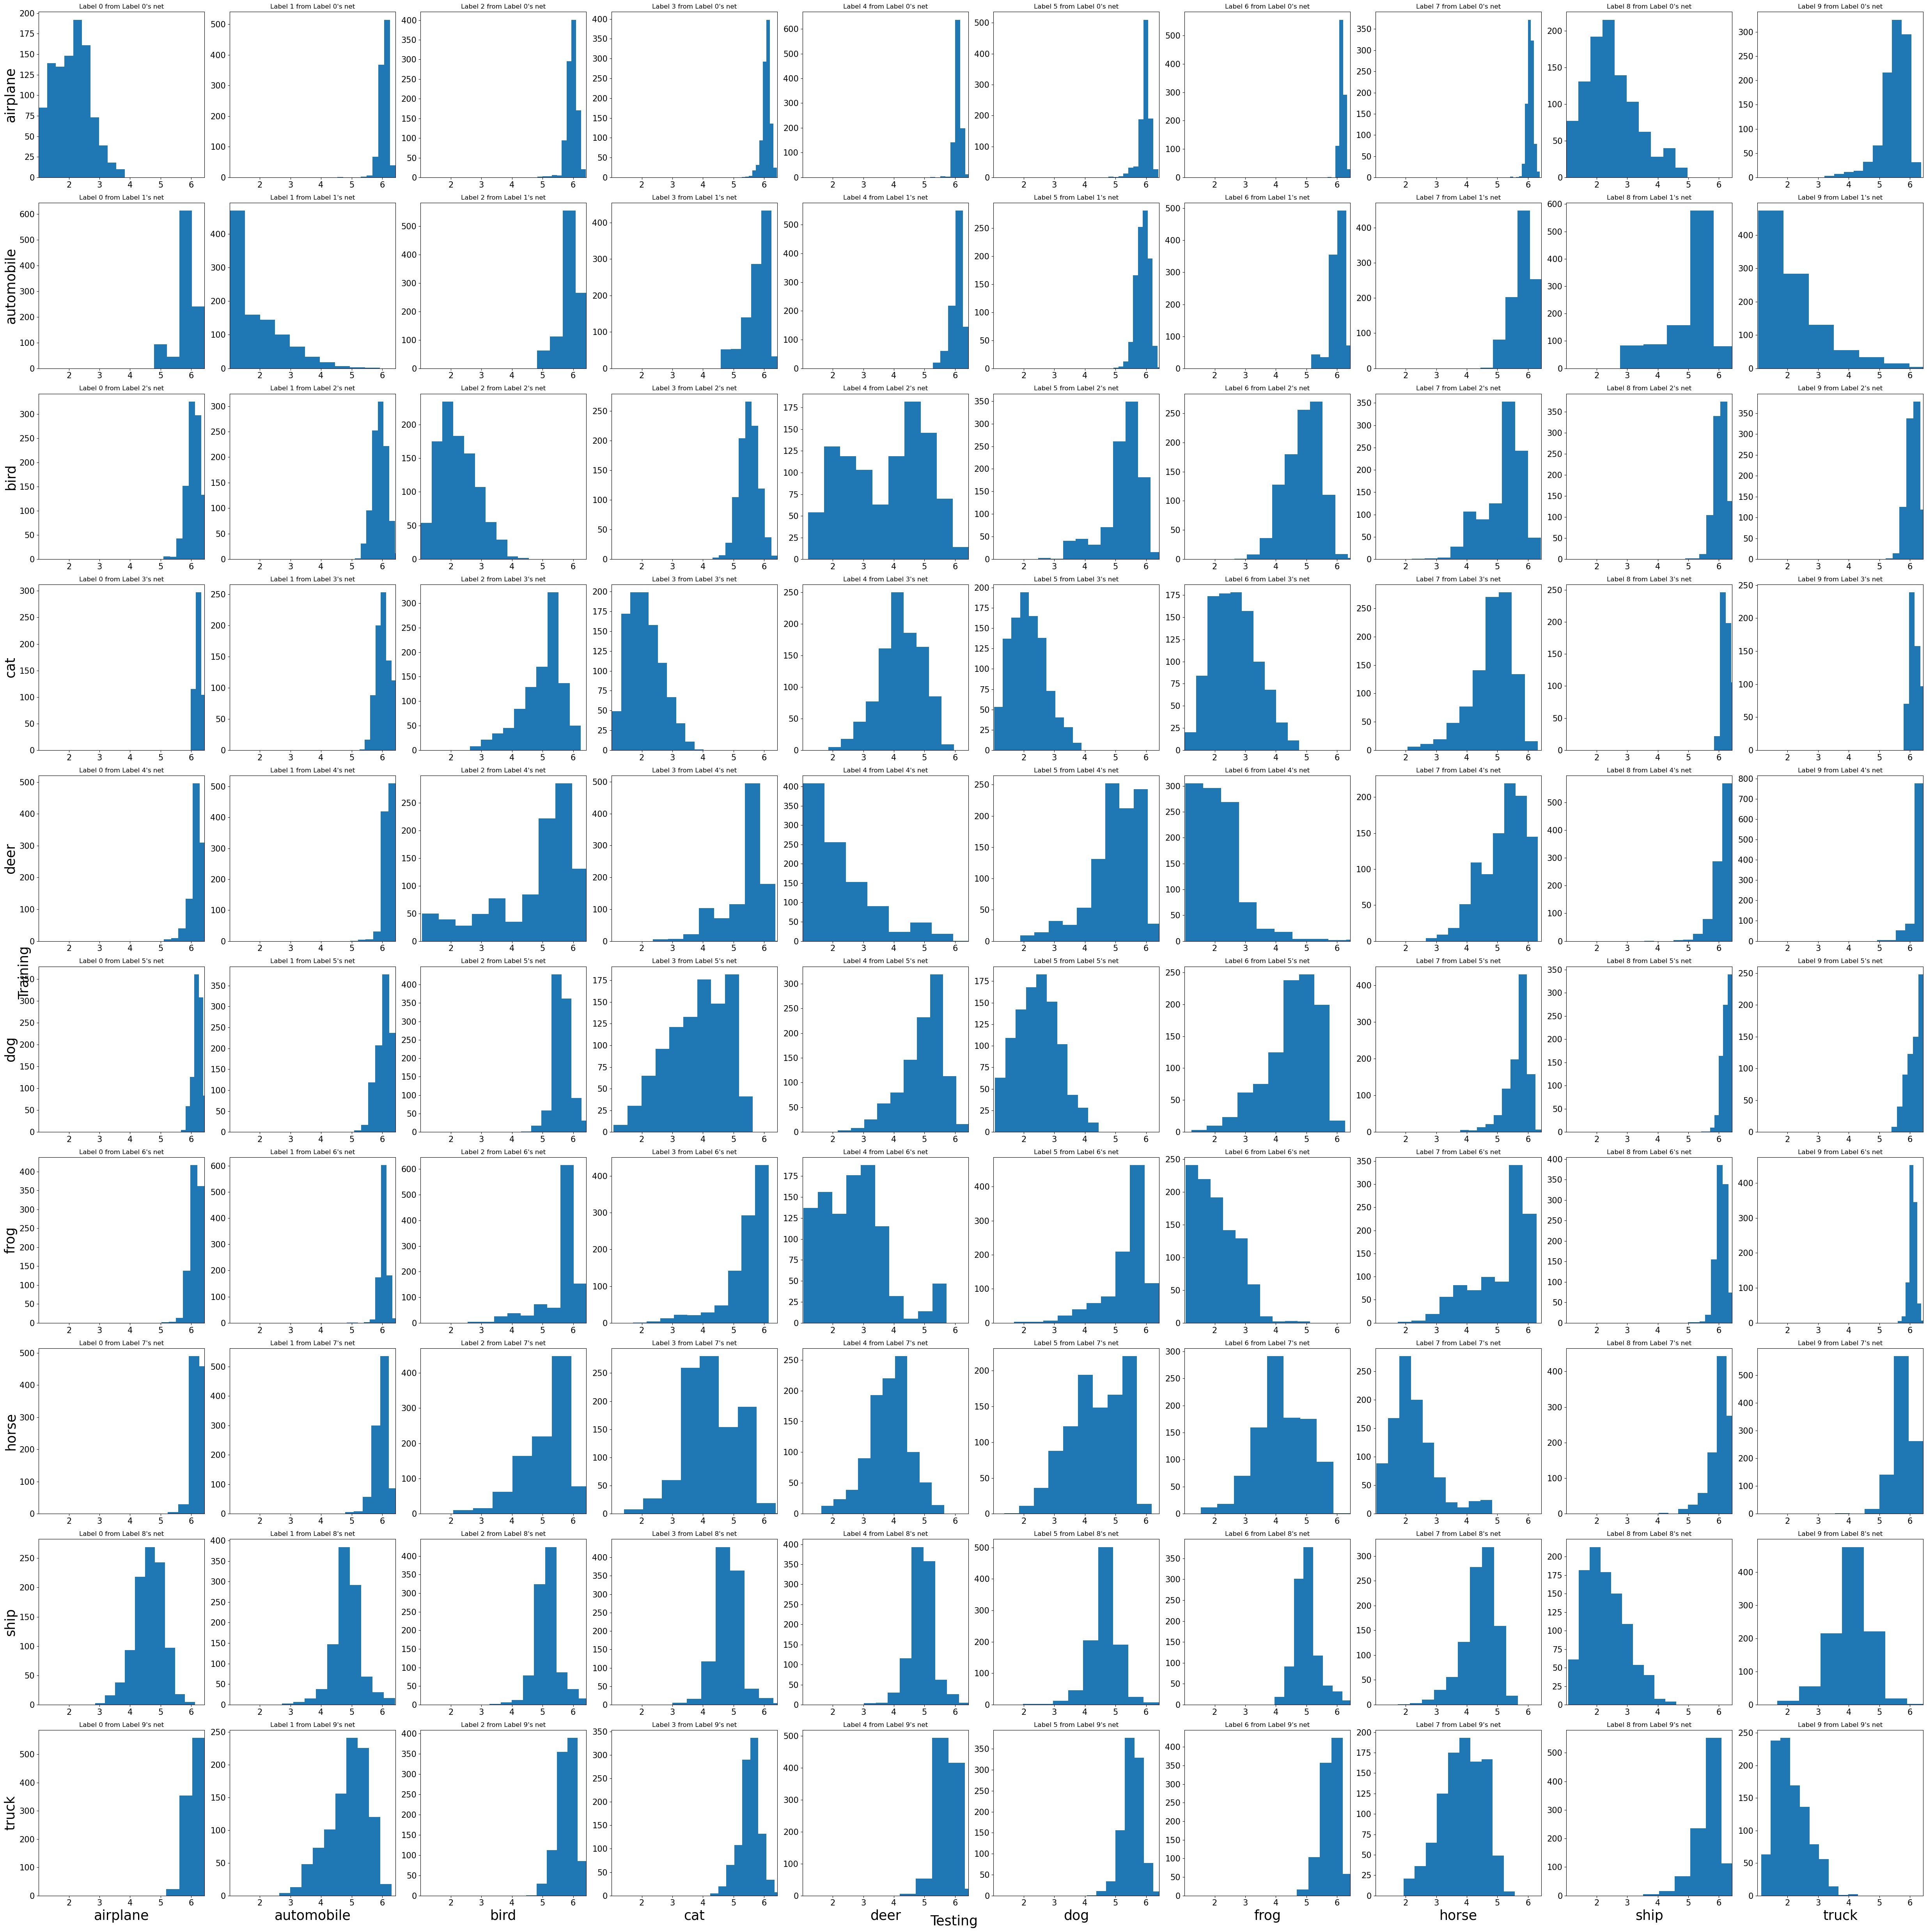

In [74]:
visualize_T(all_fake_Ts, present_label, all_label, missing_label, z_dim, classes)

----------------------------------------------------------------------------------------------------------------------------------
                                                            p-values
----------------------------------------------------------------------------------------------------------------------------------


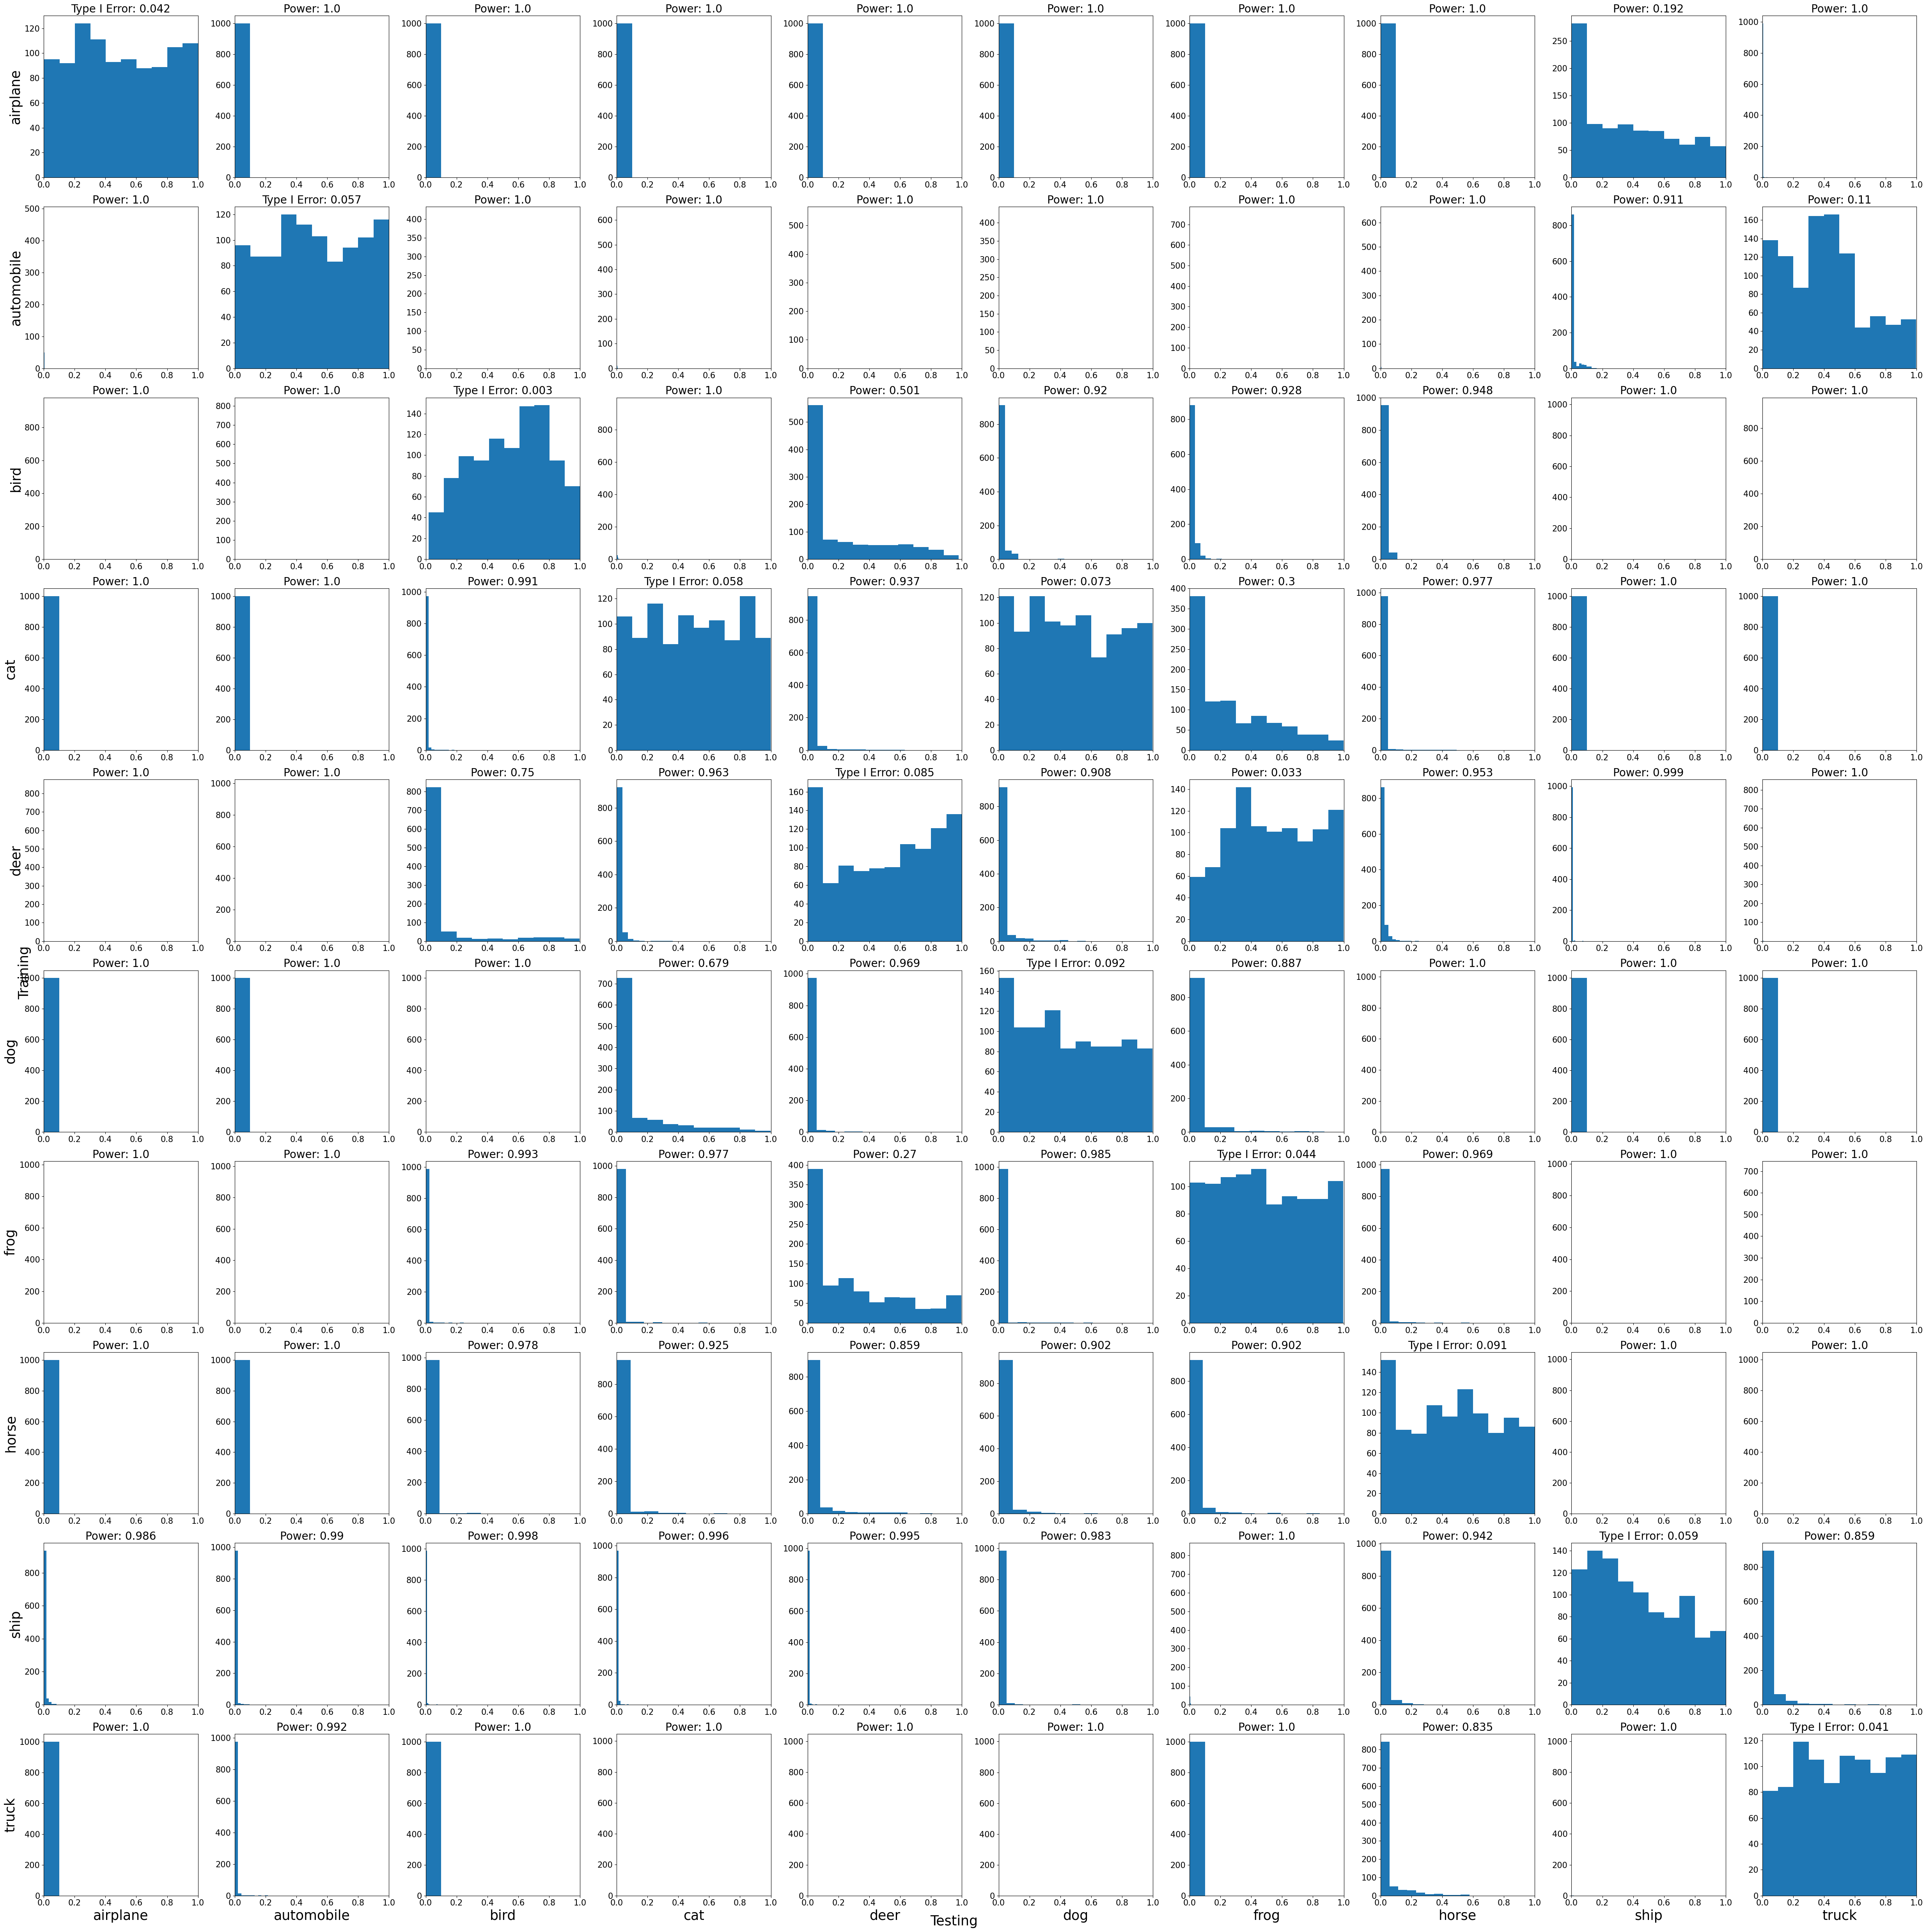

In [75]:
visualize_p(all_p_vals, present_label, all_label, missing_label, z_dim, classes)

In [119]:
cover_accs = []
avg_errors = []
n_rep = 20
for rep in range(n_rep):
    # Step 1: Generate Dirichlet distribution weights
    weights = np.random.dirichlet([dirichlet_alpha] * len(all_label))
    # Step 2: Calculate the number of samples for each class
    total_samples = len(test_gen.data)
    samples_per_class = np.round(weights * total_samples).astype(int)
    # Adjust to make sure the total is equal to the original test set size
    samples_per_class[-1] = total_samples - np.sum(samples_per_class[:-1])

    ## test data set
    sampled_p_vals  = []
    
    for idx, lab in enumerate(all_label):    
        
        p_vals = all_p_vals[idx]
        n = p_vals.shape[1]
        class_idxs = np.random.choice(np.arange(n), size=samples_per_class[idx], replace=True)
        # class_idxs = idxs2
        sampled_p_vals.append(p_vals[:,class_idxs])
    
    # cover_acc = torch.zeros(len(all_label))
    # avg_error = torch.zeros(len(all_label))
    cover = 0.0
    error = 0.0
    for i, lab in enumerate(all_label):
        p_vals = sampled_p_vals[i]
        n = p_vals.shape[1]
        for j in range(n):
            pred = np.argmax(p_vals[:, j])
            p_set = np.where(p_vals[:, j] > 0.05)[0]
            # counts += len(p_set)
            if lab in missing_label:
                error += len(p_set)
                if len(p_set) == 0:
                    cover += 1
            else:
                error += abs(len(p_set) - 1) 
                if all_label[i] in p_set:
                    cover += 1
        # cover_acc[i] = cover / n 
        # avg_error[i] = error / n 
    cover_acc = cover / total_samples 
    avg_error = error / total_samples 
    cover_accs.append(cover_acc)
    avg_errors.append(avg_error)
    print(f'rep = {rep+1}')

rep = 1
rep = 2
rep = 3
rep = 4
rep = 5
rep = 6
rep = 7
rep = 8
rep = 9
rep = 10
rep = 11
rep = 12
rep = 13
rep = 14
rep = 15
rep = 16
rep = 17
rep = 18
rep = 19
rep = 20


In [121]:
print(np.mean(cover_accs))
print(np.std(cover_accs))
print(np.mean(avg_errors))
print(np.std(avg_errors))

0.9433450000000001
0.005084729589663539
0.7392800000000002
0.07947379819789666
